In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [3]:
import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import src.visualization.visualize as VizManager
import src.features.build_features as FeaturesManager

In [5]:
SEED = 42

In [6]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
features_data = FeaturesManager.build_features(seasons_year, season_type)

In [7]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305860 entries, 0 to 305859
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Game ID                         305860 non-null  object 
 1   Event Index                     305860 non-null  int64  
 2   Period                          305860 non-null  int64  
 3   Team                            305860 non-null  object 
 4   Type                            305860 non-null  object 
 5   Shot Type                       305827 non-null  object 
 6   Shooter                         305860 non-null  object 
 7   Shooter ID                      305860 non-null  int64  
 8   Goalie                          305860 non-null  object 
 9   Goalie ID                       305860 non-null  int64  
 10  Strength                        28689 non-null   object 
 11  X                               305860 non-null  float64
 12  Y               

In [8]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline # Outlier not integrated in pipeline actually

In [9]:
# Separate features from target
X = features_data.drop(['Is Goal', 'Type'], axis=1)
y = features_data['Is Goal']

In [10]:
# Data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [11]:
import warnings 
warnings.filterwarnings("ignore")

In [12]:
# Check how many shots are in defensive zone - these are potentially outliers if not empty net
out = X_train[X_train['st_X'] < -25]['st_X'].count()
X_train.shape[0] - out # we should expect approximately this much rows left after outlier removal

235128

<AxesSubplot:xlabel='st_X'>

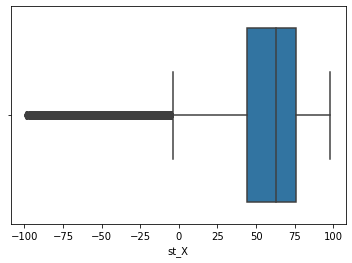

In [13]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Outliers - Boxplot
sns.boxplot(x=X_train['st_X']) # hahaha

In [14]:
# Outliers - Percentile
min_thresold, max_thresold = X_train['st_X'].quantile([0.05, 0.95]) # define threshold

percentile_mask = (X_train['st_X']<max_thresold) & (X_train['st_X']>min_thresold) # create bool mask for threshold

X_train_percentile = X_train[percentile_mask]
y_train_percentile  = y_train[percentile_mask]

X_train_percentile.shape, y_train_percentile.shape

((216353, 32), (216353,))

<AxesSubplot:xlabel='st_X', ylabel='Count'>

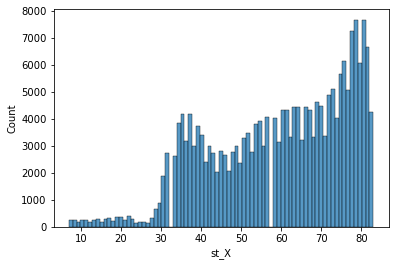

In [15]:
sns.histplot(X_train_percentile['st_X'])

In [16]:
# Outliers - STD
factor = 2
upper_limit = X_train['st_X'].mean() + factor*X_train['st_X'].std()
lower_limit = X_train['st_X'].mean() - factor*X_train['st_X'].std()

std_mask = (X_train['st_X']<upper_limit) & (X_train['st_X']>lower_limit)

X_train_std = X_train[std_mask]
y_train_std = y_train[std_mask]

X_train_std.shape, X_train_std.shape 

((234121, 32), (234121, 32))

<AxesSubplot:xlabel='st_X', ylabel='Count'>

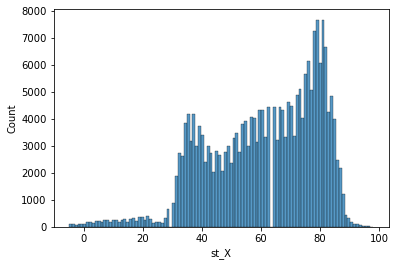

In [17]:
sns.histplot(X_train_std['st_X'])

In [18]:
# Outliers - Z-Score
threshold = 3
zscore_mask = (np.abs(stats.zscore(X_train['st_X'])) < threshold)

X_train_zscore = X_train[zscore_mask]
y_train_zscore = y_train[zscore_mask]

X_train_zscore.shape, y_train_zscore.shape

((235964, 32), (235964,))

<AxesSubplot:xlabel='st_X', ylabel='Count'>

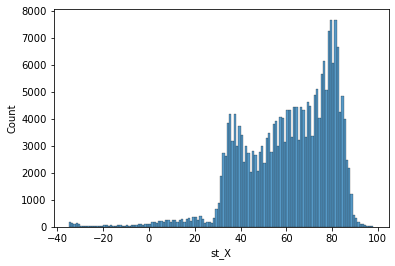

In [19]:
sns.histplot(X_train_zscore['st_X'])

In [ ]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma='auto').fit_predict(X_train[['st_X']]) # So slow, i killed the kernel, not sure how to interpret the result

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor().fit_predict(X_train[['st_X']])